In [92]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# Clean the main dataset

In [36]:
# load the mian data
data = pd.read_csv('train.csv')
data = data[['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent']]

In [37]:
# The dataset is organized in such a way that when the number of mosquitos exceed 50, 
# they are split into another record (another row in the dataset), 
# such that the number of mosquitos are capped at 50. 
# So there may be a possibility that everything in two rows is the same except for the presence of virus.
# In this case the algorithm may be confused if I feed the data as it is.
# So I calculate the total number of mos of same species for one trap each day by aggregating rows.
mos = data.groupby(['Date', 'Species', 'Trap', 'Latitude', 'Longitude']).NumMosquitos.sum()
wnv = data.groupby(['Date', 'Species', 'Trap', 'Latitude', 'Longitude']).WnvPresent.sum()

# put number of mos and virus present back together
df = pd.concat([mos, wnv], axis=1)
df.reset_index(level=['Date', 'Species', 'Trap', 'Latitude', 'Longitude'], inplace=True)
df.WnvPresent = df.WnvPresent.apply(lambda x: 1 if x>=1 else 0)

In [38]:
df.Date = pd.to_datetime(df.Date)

# Clean the weather dataset

In [39]:
weather = pd.read_csv("weather.csv")

In [40]:
weather.drop('CodeSum', axis=1, inplace=True)

In [41]:
# Clean data based on the data dictionary
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', -1)
weather = weather.replace(' T', -1)
weather = weather.replace('  T', -1)

In [42]:
weather.Tavg = pd.to_numeric(weather.Tavg)

In [43]:
# There are weather data for one day from two different stations.
# Since I cannot tell which would be predictive, I decided to combine two stations data for each day into one row
# and put everything into model and let the model decides which data is more useful
# First I split weather data from different stations
weather1 = weather[weather['Station']==1]
weather2 = weather[weather['Station']==2]
weather1 = weather1.drop('Station', axis=1)
weather2 = weather2.drop('Station', axis=1)

In [44]:
# rename columns so that after feature selection I could identify where the feature is from
weather1.columns = weather1.columns + str(1)
weather1.rename(columns={'Date1': 'Date'}, inplace=True)
weather2.columns = weather2.columns +str(2)
weather2.rename(columns={'Date2': 'Date'}, inplace=True)

In [45]:
# merge weather data to put weather data for each day in one single row
weather = weather1.merge(weather2, on='Date')

In [46]:
weather.Date = pd.to_datetime(weather.Date)

In [47]:
# merge weather data to the main dataframe
df = pd.merge(df, weather, on='Date', how='left')

# Utilize spray data

In [48]:
# create time variables in the main dataframe to use to merge spray data
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df['Week'] = df.Date.dt.week
df['Day'] = df.Date.dt.day

In [ ]:
# we think one spray will have a lasting effect for 3 weeks in a certain area, 
# so the following code is essentially trying to merge spray to the main dataset on spray date and location,
# and assaign spray=1 to the records that within 3 weeks after spray

In [49]:
# we think spray will have a wild range of effect, so we round the coordinates to 2 decimal place and merge on that

spray = pd.read_csv("spray.csv")
df['merge_latitude'] = df.Latitude.apply(lambda x: round(x, 2))
df['merge_longitude'] = df.Longitude.apply(lambda x: round(x, 2))
spray['merge_latitude'] = spray.Latitude.apply(lambda x: round(x, 2))
spray['merge_longitude'] = spray.Longitude.apply(lambda x: round(x, 2))

In [50]:
spray.Date = pd.to_datetime(spray.Date)
spray['Year'] = spray.Date.dt.year
spray['Week'] = spray.Date.dt.week
spray.drop('Time', axis=1, inplace=True)

In [51]:
spray = spray.iloc[:, 3:]

In [52]:
# the following lines of code are trying to create 3 dataframe from spray to represent spray effect for three weeks
spray['Week2'] = spray.Week + 1
spray['Week3'] = spray.Week + 2
spray['Spray1'] = 1
spray['Spray2'] = 1
spray['Spray3'] = 1

In [53]:
spray.drop_duplicates(keep='first', inplace=True)

In [54]:
# Split spray data into three dataframes in order to represent three week effects
spray_week1 = spray[['merge_latitude', 'merge_longitude', 'Year', 'Week', 'Spray1']]
spray_week2 = spray[['merge_latitude', 'merge_longitude', 'Year', 'Week2', 'Spray2']]
spray_week2.rename(columns={'Week2':'Week'}, inplace=True)
spray_week3 = spray[['merge_latitude', 'merge_longitude', 'Year', 'Week3', 'Spray3']]
spray_week3.rename(columns={'Week3':'Week'}, inplace=True)

In [55]:
# finally, merge spray data to the main dataframe
df = pd.merge(df, spray_week1, how = 'left', on=['Year', 'Week', 'merge_latitude', 'merge_longitude'])
df = pd.merge(df, spray_week2, how = 'left', on=['Year', 'Week', 'merge_latitude', 'merge_longitude'])
df = pd.merge(df, spray_week3, how = 'left', on=['Year', 'Week', 'merge_latitude', 'merge_longitude'])

In [56]:
# Get rid of NaNs. Replace them with 0s.
df.Spray1 = df.Spray1.apply(lambda x: 1 if x == 1 else 0)
df.Spray2 = df.Spray2.apply(lambda x: 1 if x == 1 else 0)
df.Spray3 = df.Spray3.apply(lambda x: 1 if x == 1 else 0)

In [57]:
# combine spray information to one single column, and drop columns used to merge
df['Sprayed'] = df.Spray1 + df.Spray2 + df.Spray3
df.drop(['merge_latitude', 'merge_longitude', 'Spray1', 'Spray2', 'Spray3'], axis=1, inplace=True)
df.drop(['Date', 'Month', 'Day'], axis=1, inplace=True)
df['wnv'] = df.WnvPresent
df.drop('WnvPresent', axis=1, inplace=True)

In [58]:
df.to_csv('wnv.csv', index=False)

# Done with cleaning

In [59]:
df = pd.read_csv('wnv.csv')

In [60]:
# label encode all the categorical features
le = LabelEncoder()
cols = [i for i in df.select_dtypes(include=['object']).columns]
df[cols] = df[cols].apply(le.fit_transform)

In [61]:
X = df.iloc[:,0:-1]
y = df.wnv

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df.wnv, random_state=42)

# Feature Selection

In [65]:
# Use random forest to select features
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [66]:
# Check the feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances

,importance
NumMosquitos,0.250594
Longitude,0.156239
Trap,0.155098
Latitude,0.152143
Species,0.059648
Sunrise1,0.025141
Week,0.021273
Sunset1,0.014671
ResultSpeed1,0.011420
ResultDir2,0.009675


In [67]:
# NumMosquitos is not available in the test dataset. The number of Traps is much less than that in the test dataset.
# Sunset time is perfectly correlated with Sunrise time, so we do not expect including it would bring extra benefits
X = df[['Longitude', 'Latitude', 'Species', 'Sunrise1', 'Week']]

# Define functions to optimize and evaluate models

In [68]:
# Define a function to optimize model with grid search
# Since it's a highly unbalanced dataset, it makes little sense to optimize accuracy score, 
# so here I use grid search to optimize roc_auc
def gridsearch(model, params):
    gs = GridSearchCV(model, params, scoring='roc_auc')
    gs.fit(X_train, y_train)
    print 'Best parameters: ', gs.best_params_
    print 'Best auc on training set: ', gs.best_score_
    print 'Best auc on test set: ', gs.score(X_test, y_test)

In [75]:
# Define a function to fit model on the whole training set with optimized parameters and check the accuracy score.
def evaluation(model):
    model.fit(X_train, y_train)
    print 'Accuracy score on test set: ', model.score(X_test, y_test)
    return model.predict(X_test), model.predict_proba(X_test)[:,1]

In [70]:
# Define a function to generate confusion matrix
def confusions(y_pred):
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['wnv', 'no wnv'], columns=['pred wnv', 'pred no wnv'])
    return confusion

In [71]:
# Define a function to plot roc curve
def plot_roc(y_prob):
    fpr = dict()
    tpr = dict()
    roc_auc=dict()
    fpr[1], tpr[1], _ = roc_curve(y_test, y_prob)
    roc_auc[1] = auc(fpr[1], tpr[1])
    plt.figure(figsize=[11,9])
    plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for WNV', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

### Random Forest

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df.wnv, random_state=42)

In [73]:
# use grid search to optimize the auc

rf_params = {'n_estimators': [5, 10, 15, 20, 30], 'criterion': ['gini', 'entropy'], 'max_features': ['auto', 'sqrt', 'log2', None],
            'max_depth': [3, 5, 10, None]}
gridsearch(rf, rf_params)

Best parameters:  {'max_features': 'log2', 'n_estimators': 20, 'criterion': 'entropy', 'max_depth': 5}
Best auc on training set:  0.821233589886
Best auc on test set:  0.823206582085


/Users/guaisang/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:426: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


In [77]:
# use the best model from grid search to check the accuracy score
# set class_weights='balanced' to capture more true positive prediction
# The score is not impressive, which is expected
rf = RandomForestClassifier(max_features='log2', n_estimators=20, criterion='entropy', max_depth=5, class_weight='balanced')
rf_pred, rf_prob = evaluation(rf)

Accuracy score on test set:  0.73535194652


In [78]:
# confusion matrix
# missclassified a lot negative class, but did very well in capturing positive class
confusions(rf_pred)

,pred wnv,pred no wnv
wnv,105,32
no wnv,641,1765


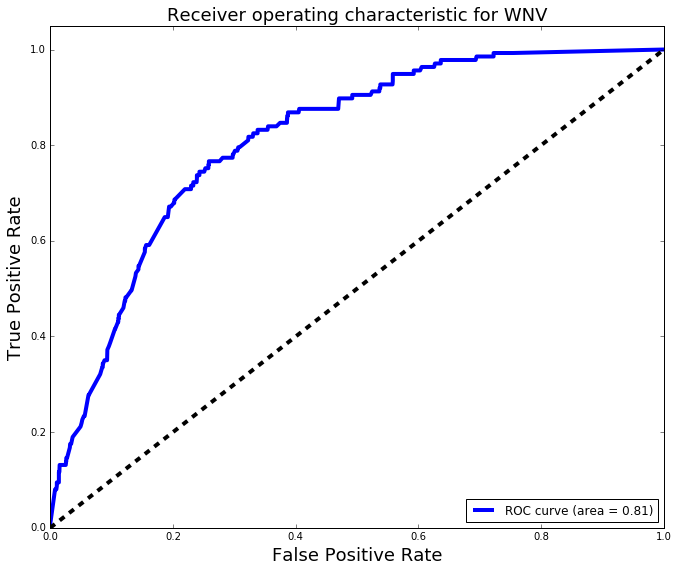

In [79]:
# plot roc curve and calculate auc
plot_roc(rf_prob)

### SVM

In [80]:
# standardize features to fit non-tree based models
# Theoratically, we should have created dummies for categorical features, 
# but doing that brought the kaggle score down
# So here I treat it as a numerical feature
numerical_features = ['Longitude', 'Latitude', 'Species', 'Sunrise1', 'Week']
for i in numerical_features:
    df[i] = (df[i]-df[i].mean())/df[i].std()

In [81]:
X = df[['Longitude', 'Latitude', 'Species', 'Sunrise1', 'Week']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=df.wnv, random_state=42)

In [82]:
sv = svm.SVC(kernel='rbf')
sv_params = {'C': 10.**np.arange(-2,3), 'gamma': 10.**np.arange(-5,2)}
gridsearch(sv, sv_params)

Best parameters:  {'C': 100.0, 'gamma': 0.0001}
Best auc on training set:  0.72689889918
Best auc on test set:  0.713635618982


In [84]:
sv = svm.SVC(kernel='rbf', C=100, gamma=0.0001, probability=True, class_weight='balanced')
sv_pred, sv_prob = evaluation(sv)

Accuracy score on test set:  0.567046795124


In [85]:
confusions(sv_pred)

,pred wnv,pred no wnv
wnv,107,30
no wnv,1071,1335


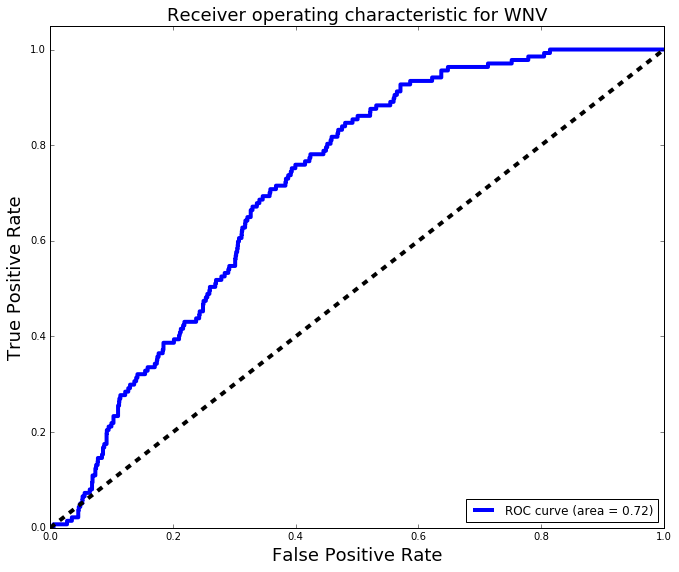

In [86]:
plot_roc(sv_prob)

### KNN

In [88]:
knn = KNeighborsClassifier()
knn_params={'n_neighbors': range(3, 80), 'weights': ['uniform', 'distance']}
gridsearch(knn, knn_params)

Best parameters:  {'n_neighbors': 41, 'weights': 'uniform'}
Best auc on training set:  0.780710508786
Best auc on test set:  0.770250468719


In [90]:
# Impressive accuracy score
knn = KNeighborsClassifier(n_neighbors=41, weights='uniform')
knn_pred, knn_prob = evaluation(knn)

Accuracy score on test set:  0.9461266221


In [95]:
# fail to predict any positive class
confusions(knn_pred)

,pred wnv,pred no wnv
wnv,0,137
no wnv,0,2406


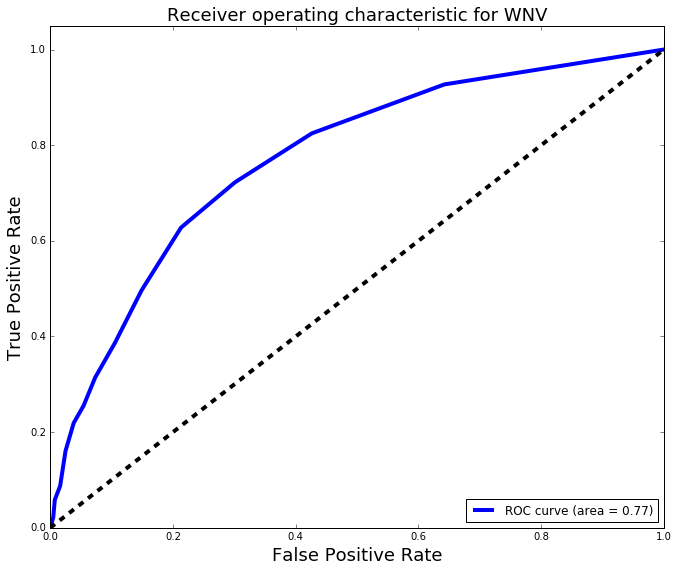

In [91]:
plot_roc(knn_prob)

### Naive Bayes (Gaussian)

In [94]:
gnb = GaussianNB()
gnb_pred, gnb_prob = evaluation(gnb)

Accuracy score on test set:  0.94534014943


In [96]:
# fail to predict positive class
confusions(gnb_pred)

,pred wnv,pred no wnv
wnv,2,135
no wnv,4,2402


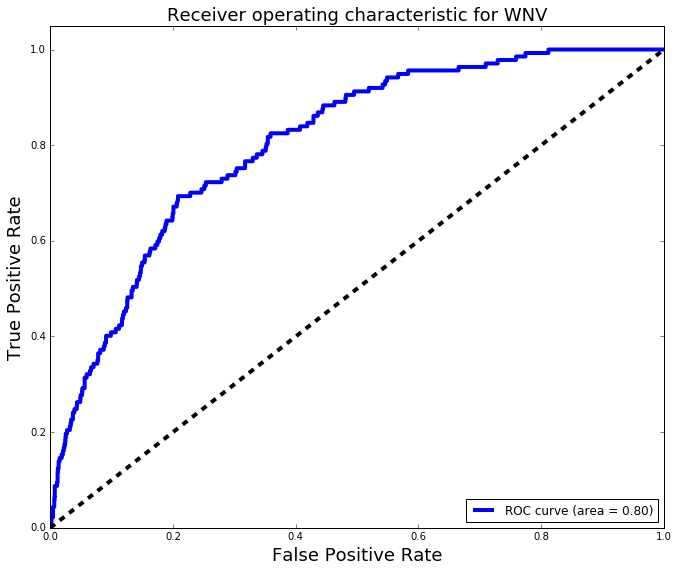

In [97]:
# Despite a poor confusion matrix, the auc is actually impressive
plot_roc(gnb_prob)

### Neural Network

In [98]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

Using Theano backend.


In [99]:
xs = X.astype(float).as_matrix()
ys = y

In [107]:
# define the neural network

def baseline_model():
    model = Sequential()
    model.add(Dense(10, input_dim=5, init='normal', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [108]:
xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.3, stratify=df.wnv, random_state=42)

In [124]:
nn = KerasClassifier(build_fn=baseline_model, nb_epoch=200, batch_size=50, verbose=0, class_weight={0:0.05, 1:0.95})

In [125]:
nn.fit(xs_train, ys_train)
print nn.score(xs_test, ys_test)
nn_pred = nn.predict(xs_test)
nn_prob = nn.predict_proba(xs_test)[:,1]

0.712937477228


In [126]:
confusions(nn_pred)

,pred wnv,pred no wnv
wnv,107,30
no wnv,700,1706


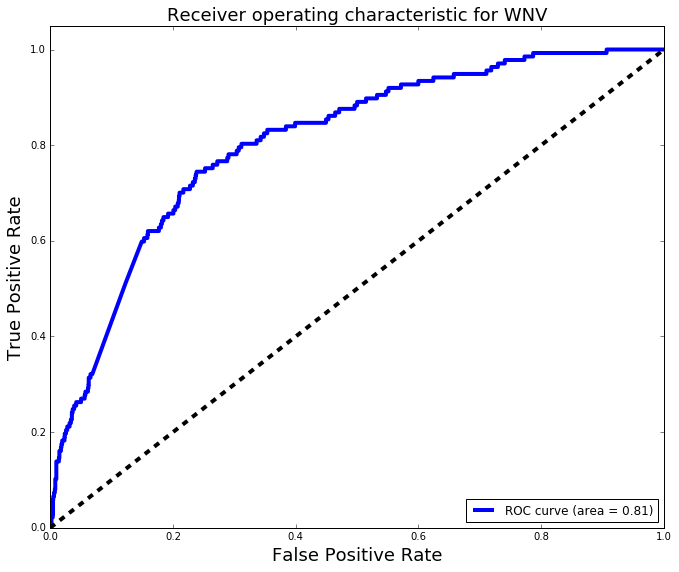

In [127]:
plot_roc(nn_prob)

# Submitting results to Kaggle

In [ ]:
# prepare the testing dataframe. we only use weather data from station 1 because that is where our features from
testing = pd.read_csv('test.csv')
weather_test = pd.read_csv('weather.csv')
weather_test = weather_test[weather_test.Station==1]
testing = pd.merge(left=testing, right=weather_test, on='Date', how='left')
testing.Date = pd.to_datetime(testing.Date)
testing['Week'] = testing.Date.dt.week
testing.Sunrise = pd.to_numeric(testing.Sunrise)
testing.rename(columns={'Sunrise': 'Sunrise1'}, inplace=True)
testing.to_csv('cleanedtest.csv', index=False)

In [ ]:
testing = pd.read_csv('cleanedtest.csv', index=False)

In [ ]:
# manually standardize numeric features
for i in numerical_features:
    testing[i] = (testing[i]-testing[i].mean())/testing[i].std()

In [ ]:
# label encoder categorical features
test_cols = [i for i in testing.select_dtypes(include=['object']).columns]
testing[test_cols] = testing[test_cols].apply(le.fit_transform)

In [ ]:
X_testing = testing[['Longitude', 'Latitude', 'Species', 'Sunrise1', 'Week']]

### Random Forest

In [ ]:
rf_test = rf.predict_proba(X_testing)[:,1]
testing['WnvPresent'] = rf_test
submit_rf = testing[['Id', 'WnvPresent']]
submit_rf.to_csv('score_rf.csv', index=False)

### SVM

In [ ]:
svm_test = clf.predict_proba(X_testing)[:,1]
testing['WnvPresent'] = svm_test
submit_svm = testing[['Id', 'WnvPresent']]
submit_svm.to_csv('score_svm.csv', index=False)

### KNN

In [ ]:
knn_test = knn.predict_proba(X_testing)[:,1]
testing['WnvPresent'] = knn_test
submit_knn = testing[['Id', 'WnvPresent']]
submit_knn.to_csv('score_knn.csv', index=False)

### Neural Network|

In [ ]:
xs_testing = X_testing.as_matrix()

In [ ]:
nn_test = estimator.predict_proba(xs_testing)[:,1]
testing['WnvPresent'] = nn_test
submit_nn = testing[['Id', 'WnvPresent']]
submit_nn.to_csv('score_nn.csv', index=False)

### Naive Bayes (gaussian)

In [ ]:
gnb_test = gnb.predict_proba(X_testing)[:,1]
testing['WnvPresent'] = gnb_test
submit_gnb = testing[['Id', 'WnvPresent']]
submit_gnb.to_csv('score_gnb.csv', index=False)